# 프로젝트: CAM을 만들고 평가해 보자

In [10]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

import os

import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import cv2
import copy
import PIL

print(tf.__version__)   # 2.6.0
print(np.__version__)   # 1.21.4
print(cv2.__version__)  # 4.5.3
print(PIL.__version__)  # 8.3.2

2.10.1
1.23.5
4.7.0
9.3.0


## 데이터 준비

In [ ]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='D:/DATA/tdfs/stanford_dogs')

# 데이터셋에 전처리와 배치처리 적용.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

## 모델 준비

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=preds)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'])

In [11]:
cam_model_path = './ckpt'
checkpoint_path = os.path.join(cam_model_path, 'best_cam_model.h5')

# ModelCheckpoint 콜백 생성
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',     
    save_best_only=True,        # 가장 좋은 모델만 저장
    save_weights_only=False,    # 전체 모델 저장
    verbose=1)

In [12]:
history_cam_model = model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint])

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 2.2534 - accuracy: 0.4328
Epoch 1: val_accuracy improved from -inf to 0.17094, saving model to ./ckpt\best_cam_model.h5
750/750 [==============================] - 60s 70ms/step - loss: 2.2534 - accuracy: 0.4328 - val_loss: 3.6202 - val_accuracy: 0.1709
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.8064
Epoch 2: val_accuracy improved from 0.17094 to 0.63841, saving model to ./ckpt\best_cam_model.h5
750/750 [==============================] - 53s 70ms/step - loss: 0.7164 - accuracy: 0.8064 - val_loss: 1.2561 - val_accuracy: 0.6384
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9435
Epoch 3: val_accuracy improved from 0.63841 to 0.65042, saving model to ./ckpt\best_cam_model.h5
750/750 [==============================] - 53s 70ms/step - loss: 0.2751 - accuracy: 0.9435 - val_loss: 1.2466 - val_accuracy: 0.6504
Epoch 4/10
750/750 [=====

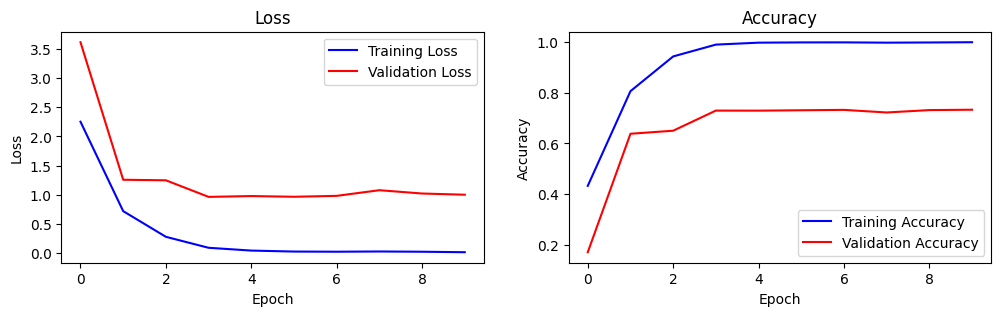

In [17]:
plt.figure(figsize=(12,3))

plt.subplot(121)
plt.plot(history_cam_model.history['loss'], 'b')
plt.plot(history_cam_model.history['val_loss'], 'r')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(122)
plt.plot(history_cam_model.history['accuracy'], 'b')
plt.plot(history_cam_model.history['val_accuracy'], 'r')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.show()

- Training Acc와 loss가 각각 100%와 0에 가깝게 수렴하였다.
- Validaton Loss가 감소하다가 큰 변동없이 평탄하게 유지되다가 미세하게 증가하기 시작했다.
- Validation Acc역시 증가하다가 큰 변동없이 평탄하게 유지되었다.
- 안정적으로 수렴하여 추가 학습으로 Loss나 Acc의 개선 가능성이 낮아보인다.
- 이번 프로젝트에서는 분류 모델의 Class Activation Map을 확인하기 위한 것이므로 높은 정확도의 모델을 필요로 하지 않는다.
    - 120개의 클래스를 70% 이상의 정확도로 분류하고 있으므로 CAM을 확인하기에는 충분하다고 판단된다.
- 이것으로 모델의 분류기 학습을 종료한다.

# CAM 구현하기

- 샘플 확보

67


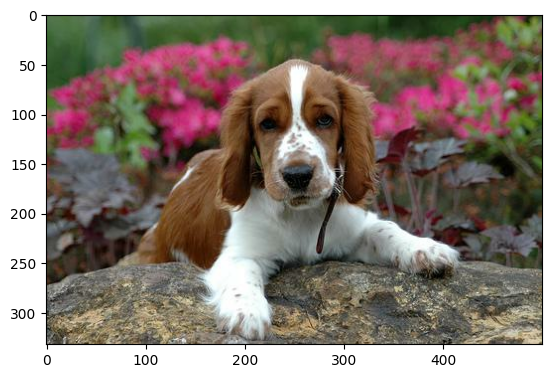

In [28]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

1. CAM 함수

In [ ]:
# 학습 후 커널 재시작한 경우에 사용
# model_path = './ckpt/best_cam_model.h5' 
# model = tf.keras.models.load_model(model_path)

In [29]:
# GAP 직전 레이어의 출력과 모델의 최종 출력을 활용
cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])

In [30]:
def generate_cam(item): # TODO: generate cam image
    # 원본 유지를 위해 복사
    item = copy.deepcopy(item)
    
    # 원본 복원을 위한 사이즈 저장
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 전처리 진행 및 이미지, 레이블 분리
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # GAP전의 Conv output과 모델 예측 결과
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델 예측 결과의 가중치 추출
    class_weights = model.layers[-1].get_weights()[0] 
    
    # GAP전의 Conv Outpus size의 행렬 초기화(채널 수 무시)
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    # Label값(클래스)에 해당하는 가중치와 Conv Outputs의 채널값의 곱한 결과 합하기
    # => 활성화 수치 입력. 즉, CAM 생성
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # 활성화 수치 0~1 값으로 정규화
    cam_image = cam_image.numpy()  # Tensor to Numpy
    cam_image[cam_image < 0] = 0   # 음수값으로 인한 오류 방지
    cam_image = cv2.resize(cam_image, (width, height)) # 원본 크기로 resize
    return cam_image

2. 만든 함수로 CAM 이미지를 생성.

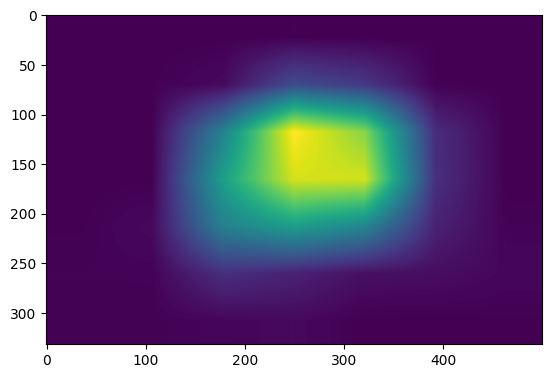

In [31]:
cam_image = generate_cam(item)
plt.imshow(cam_image)

3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 `visualize_cam_on_image()` 함수.

In [32]:
def visualize_cam_on_image(item, cam_image): # TODO: blend image
    origin_image = item['image'].astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    merged_image = cv2.addWeighted(origin_image, 0.3, cam_image_3channel, 0.7, 0.0)
    plt.imshow(merged_image)

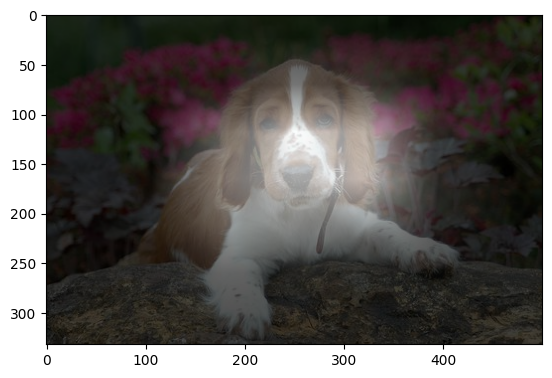

In [33]:
visualize_cam_on_image(item, cam_image)

# Grad-CAM 구현하기

1. Grad-CAM 함수

In [34]:
def generate_grad_cam(model, activation_layer, item): # TODO: generate grad_cam_image
    # 원본 유지를 위해 복사
    item = copy.deepcopy(item)
    
    # 원본 복원을 위한 사이즈 저장
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 전처리 진행 및 이밎, 레이블 분리
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 예측 클래스 값
        output = conv_output[0] # 설정한 layer의 output
        grad_val = tape.gradient(loss, conv_output)[0] # 예측 클래스의 대한 Layer의 gradient

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight 계산
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱한 값을 누적해서 class activation map 완성
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image) # 음수값 0으로 수정
    grad_cam_image /= np.max(grad_cam_image)            # 정규화
    grad_cam_image = grad_cam_image.numpy()             # Tensor to Numpy
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))    # 원본 사이즈로 복원
    
    return grad_cam_image

2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인.

In [ ]:
# output 레이어명 수집
layer_list = []
for layer in model.layers:
    if layer.name.split("_")[-1] == "out":
        layer_list.append(layer.name)
layer_list

['conv2_block1_out',
 'conv2_block2_out',
 'conv2_block3_out',
 'conv3_block1_out',
 'conv3_block2_out',
 'conv3_block3_out',
 'conv3_block4_out',
 'conv4_block1_out',
 'conv4_block2_out',
 'conv4_block3_out',
 'conv4_block4_out',
 'conv4_block5_out',
 'conv4_block6_out',
 'conv5_block1_out',
 'conv5_block2_out',
 'conv5_block3_out']

In [37]:
# 레이어별 CAM 시각화 함수
def show_grad_cams(item):
    plt.figure(figsize=(12, 35))

    for i in range(len(layer_list)):
        grad_cam_image = generate_grad_cam(model, layer_list[i], item)
        plt.subplot(8,2,i+1)
        plt.imshow(grad_cam_image)
        plt.title(f"{layer_list[i]}")
    

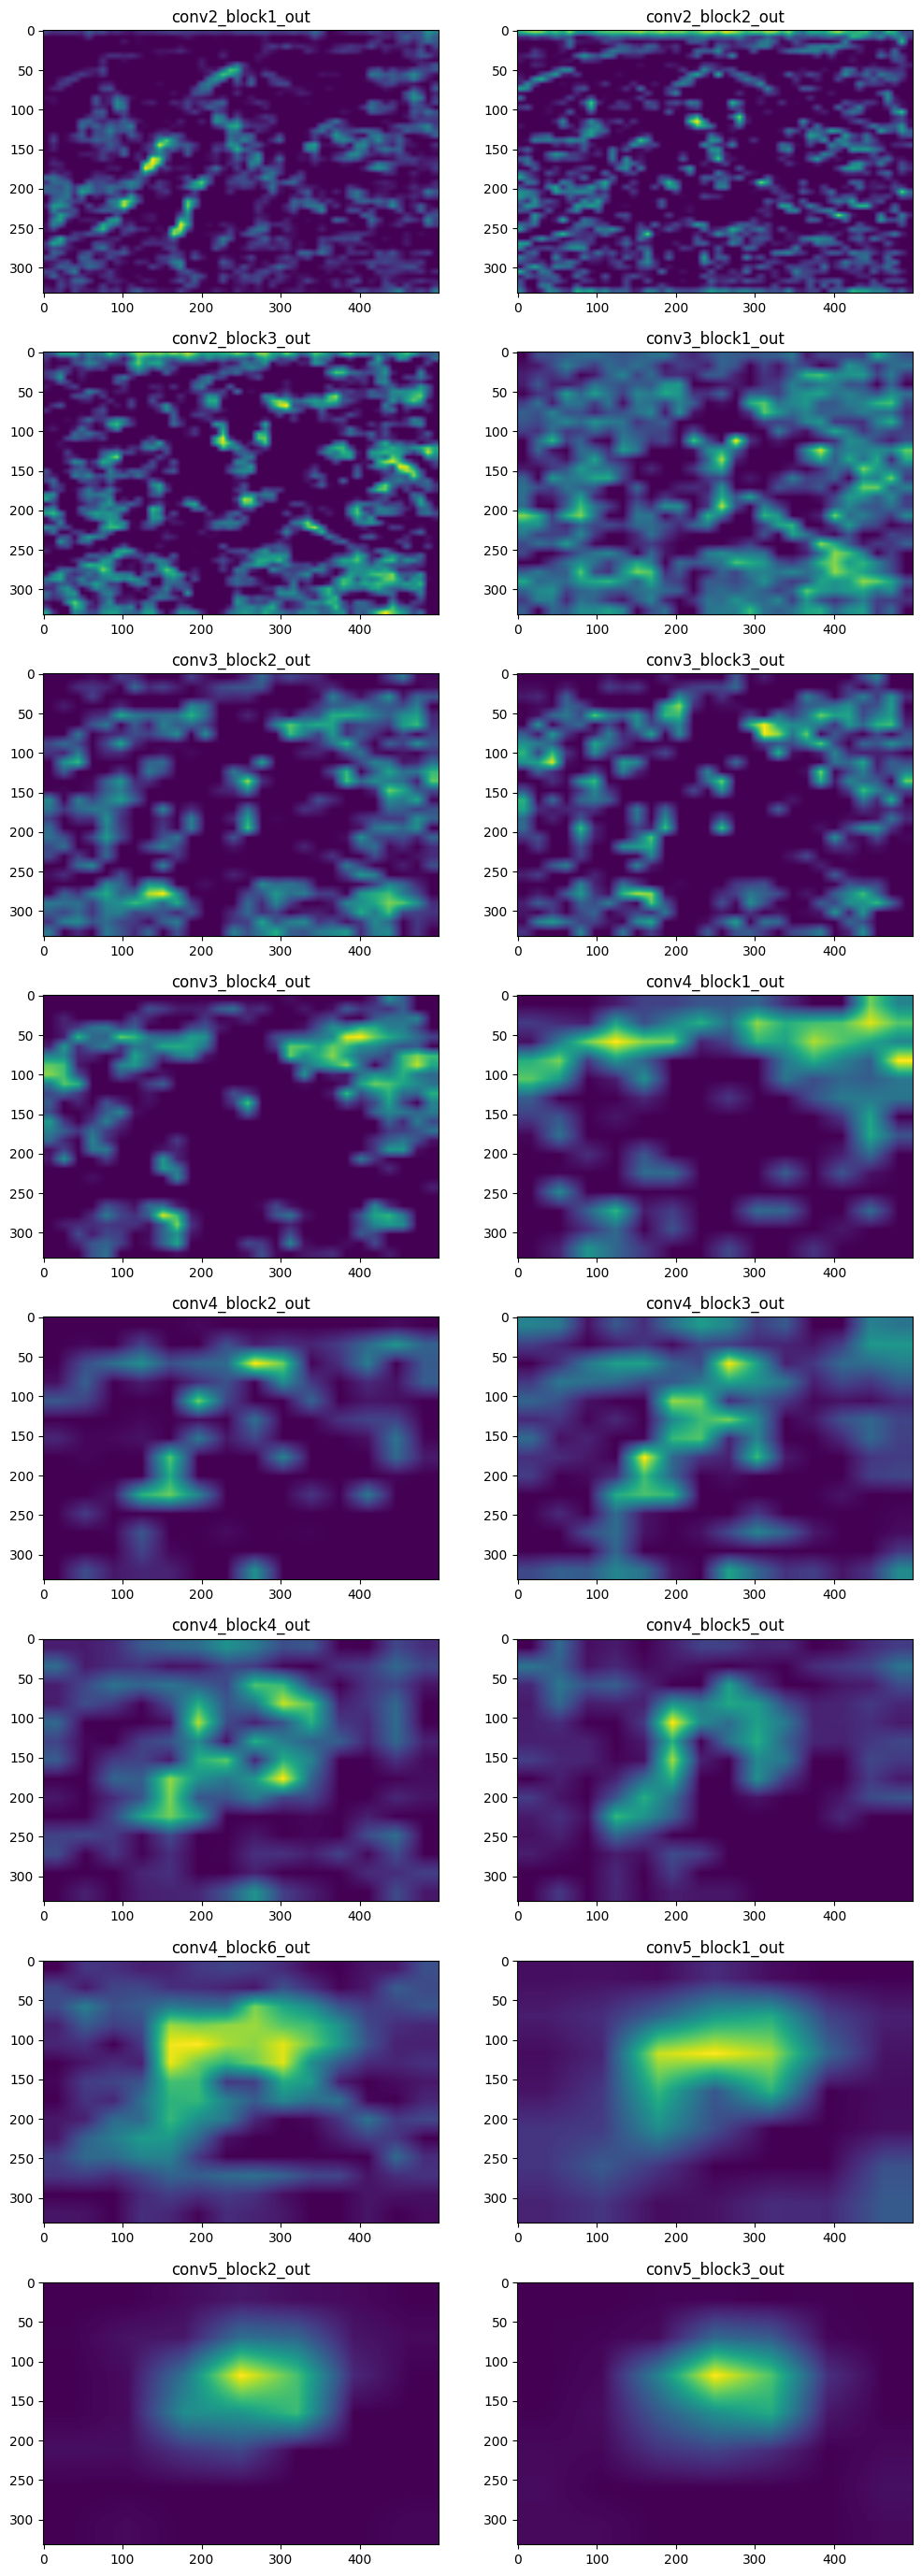

In [38]:
show_grad_cams(item)

- Conv5에서의 출력은 활용할 수 있을 것 같아 보인다.

3. 위에서 만든 이미지 `visualize_cam_on_image()` 함수로 이미지를 시각화.

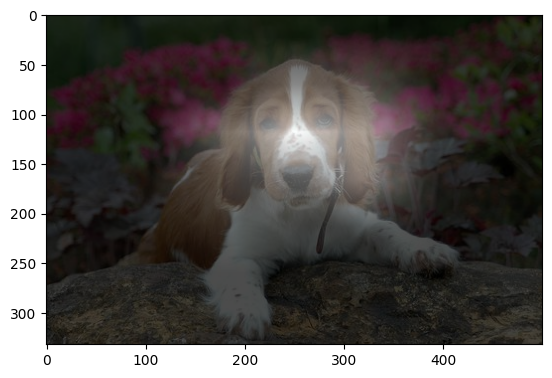

In [39]:
grad_cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
visualize_cam_on_image(item, grad_cam_image)

# 바운딩 박스 구하기

1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스 구하기.

In [40]:
def get_bbox(cam, score_thresh=0.25):
    cam = copy.deepcopy(cam)
    low_indicies = cam <= score_thresh
    cam[low_indicies] = 0
    cam = (cam*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    rect = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.int32)
    return rect

In [41]:
get_bbox(grad_cam_image)

array([[146,  59],
       [379,  59],
       [379, 205],
       [146, 205]])

2. 1)에서 얻은 바운딩 박스를 시각화.

In [43]:
def draw_bbox(item, cam_image, threshold=0.25):
    image = copy.deepcopy(item['image'])
    rect = get_bbox(cam_image, score_thresh=threshold) # 1 과정을 내부에 포함
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.imshow(image)
    plt.show()

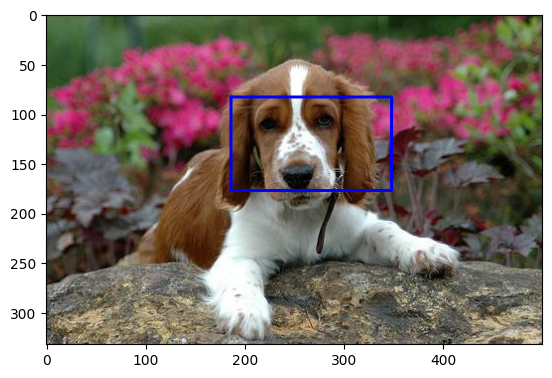

In [47]:
draw_bbox(item, grad_cam_image, threshold=0.5)

- 임계값 0.5에서는 눈, 코 위주로만 바운딩 박스 형성

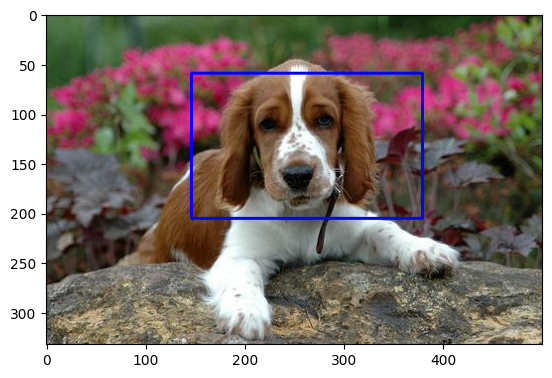

In [45]:
draw_bbox(item, grad_cam_image)

- 기본값으로 설정한 임계값 0.25에서는 얼굴 정도만 포함하는 바운딩 형성

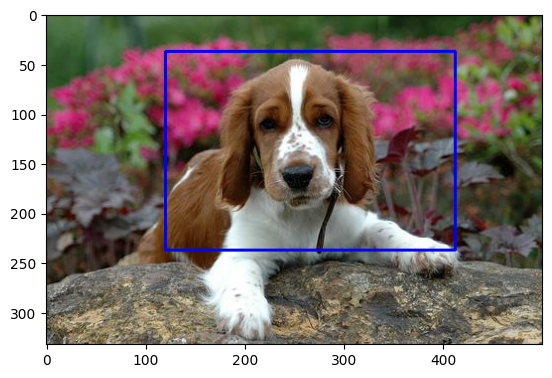

In [46]:
draw_bbox(item, grad_cam_image, threshold=0.1)

- 임계값 0.1에서 몸통까지 포함하는 바운딩 박스 형성
- 눈코입을 기준으로 바운딩 박스를 넓힌 정도의 효과에 그침.

## 추가 확인

1. 같은 이미지에 대한 Grad-CAM과 CAM의 바운딩 박스, Ground Truth 비교

In [116]:
def compare_bbox(item, cam_image, grad_cam_image, threshold=0.25):
    img = copy.deepcopy(item['image'])

    # Ground Truth Bounding Box 좌표값
    gt_y_min, gt_x_min, gt_y_max, gt_x_max = item['objects']['bbox'][0]

    # Ground Truth Bbox 그리기
    h, w, _ = item['image'].shape
    img = cv2.rectangle(img,
                        (int(gt_x_min*w), int(gt_y_min*h)), (int(gt_x_max*w), int(gt_y_max*h)),
                        (255,0,0), 2)
    
    rect1 = get_bbox(cam_image, score_thresh=threshold)
    rect2 = get_bbox(grad_cam_image, score_thresh=threshold)
    img = cv2.drawContours(img, [rect1], 0, (0,0,255), 2)
    img = cv2.drawContours(img, [rect2], 0, (0,255,0), 2)
    
    print("Red: Ground Truth, Green: Grad-CAM, Blue: CAM")

    plt.imshow(img)


Red: Ground Truth, Green: Grad-CAM, Blue: CAM


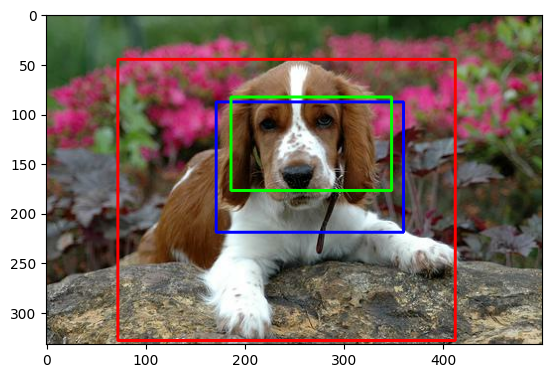

In [159]:
compare_bbox(item, cam_image, grad_cam_image, threshold=0.5)

- 임계값 0.5에서 눈, 코만 포함됐던 Grad-Cam과는 달리 눈코입 전부 포함

Red: Ground Truth, Green: Grad-CAM, Blue: CAM


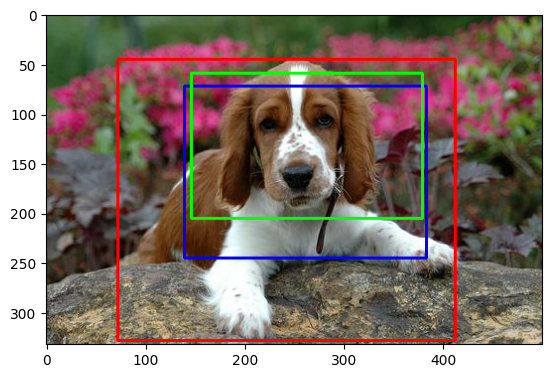

In [158]:
compare_bbox(item, cam_image, grad_cam_image, threshold=0.25)

- 임계값 0.25에서 얼굴만 포함했던 Grad-Cam과는 달리 몸통까지 포함

Red: Ground Truth, Green: Grad-CAM, Blue: CAM


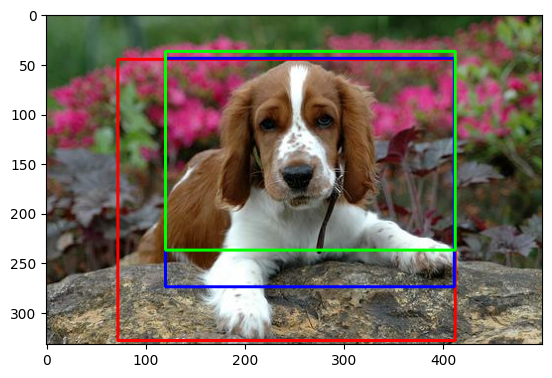

In [157]:
compare_bbox(item, cam_image, grad_cam_image, threshold=0.1)

- 임계값 0.1에서 정수리 보다 조금 위로 그려졌던 Grad-Cam과는 달리 강아지의 영역으로 벗어나지 않는 바운딩 박스 형성.

Red: Ground Truth, Green: Grad-CAM, Blue: CAM


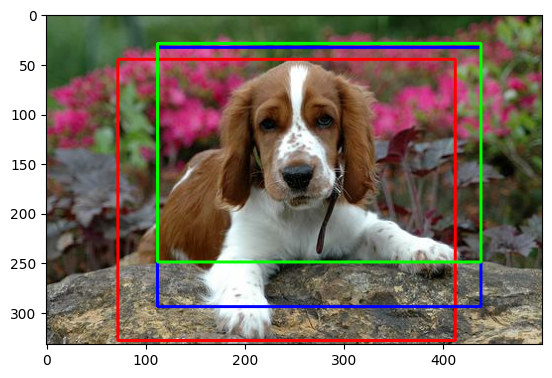

In [119]:
compare_bbox(item, cam_image, grad_cam_image, threshold=0.05)

- 해당 사진 기준, 육안으로 보았을 때는 CAM이 더 잘 그리는 것처럼 보임.
    - IOU 수치로 정확한 비교 필요.

# IoU 구하기

1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 `get_iou()` 함수.

In [ ]:
def get_iou(grad_cam_image, item, threshold=0.25):# TODO: get iou between two bbox    
    # 예측 바운딩 박스
    rect = get_bbox(grad_cam_image, score_thresh=threshold)
    pred_bbox = [
        rect[:,1].min()/float(item['image'].shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(item['image'].shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(item['image'].shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(item['image'].shape[1]) #bounding box의 x_max
    ]
    
    # 실제 바운딩 박스
    gt_bbox = item['objects']['bbox'][0]
    
    # 교차 박스
    y_min = max(pred_bbox[0], gt_bbox[0])
    x_min= max(pred_bbox[1], gt_bbox[1])
    y_max = min(pred_bbox[2], gt_bbox[2])
    x_max = min(pred_bbox[3], gt_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)   # 교차 영역
    pred_Area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])   # 예측 영역
    truth_Area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])  # 실제 영역
    iou = interArea / float(pred_Area + truth_Area - interArea)
    
    return iou

In [ ]:
# def get_iou(grad_cam_image, item, threshold=0.25):# TODO: get iou between two bbox    
#     # 예측 바운딩 박스
#     pred_bbox = get_bbox(grad_cam_image, score_thresh=threshold)
#     pr_x_min, pr_x_max = (pred_bbox[:, 0] / item['image'].shape[1])[:2]
#     pr_y_min, pr_y_max = (pred_bbox[:, 1] / item['image'].shape[0])[1:3]
    
#     # 실제 바운딩 박스
#     gt_y_min, gt_x_min, gt_y_max, gt_x_max = item['objects']['bbox'][0]
    
#     # 교차 박스
#     y_min = max(pr_y_min, gt_y_min)
#     x_min= max(pr_x_min, gt_x_min)
#     y_max = min(pr_y_max, gt_y_max)
#     x_max = min(pr_x_max, gt_x_max)
    
#     interArea = max(0, x_max - x_min) * max(0, y_max - y_min)   # 교차 영역
#     pred_Area = (pr_y_max - pr_y_min) * (pr_x_max - pr_x_min)   # 예측 영역
#     truth_Area = (gt_y_max - gt_y_min) * (gt_x_max - gt_x_min)  # 실제 영역
#     iou = interArea / float(pred_Area + truth_Area - interArea)
    
#     return iou

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교.

In [ ]:
# 비교 함수
def compare_iou(item, cam_image, grad_cam_image, threshold=0.05):
    cam_iou = get_iou(cam_image, item, threshold=threshold)
    grad_iou = get_iou(grad_cam_image, item, threshold=threshold)

    print(f"Threshold: {threshold}")
    print(f'CAM IOU \t: {cam_iou:.2%}')
    print(f'Grad-CAM IOU\t: {grad_iou:.2%} ({(cam_iou - grad_iou)*-1:.2%})')
    print("="*50)

In [197]:
# Threshold 별 비교
for thres in [0.25, 0.1, 0.05]:
    compare_iou(item, cam_image, grad_cam_image, threshold=thres)

Threshold: 0.25
CAM IOU 	: 43.87%
Grad-CAM IOU	: 35.35% (-8.52%)
Threshold: 0.1
CAM IOU 	: 69.05%
Grad-CAM IOU	: 56.89% (-12.16%)
Threshold: 0.05
CAM IOU 	: 70.47%
Grad-CAM IOU	: 57.64% (-12.83%)


- Threshold가 낮아질 수록 CAM과 Grad-CAM과의 IOU 격차는 더 벌어졌다.
    - 해당 사진 기준으로는 CAM이 Grad-CAM보다 더 바운딩 박스를 정확하게 그렸다.

- CAM의 문제점을 보완하여 Grad-CAM이 나왔다고 하여 Object Localization 성능이 Grad-CAM이 더 좋을 것이라고 예상했다.
    - 해당 결과만 보면 그렇지 않아보인다. 다만, 하나의 결과만으로는 성급한 일반화이므로 추가 실험을 진행할 필요가 있다.

# 추가 실험 1

- Grad-CAM을 다른 레이어의 CAM을 활용해보기

In [146]:
def record_iou(item, cam_image, grad_cam_image):
    thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    cam_ious, grad_ious = [], []

    for threshold in thresholds:
        cam_ious.append(get_iou(cam_image, item, threshold=threshold))
        grad_ious.append(get_iou(grad_cam_image, item, threshold=threshold))

    return cam_ious, grad_ious

In [151]:
def visualize_iou_on_threshold(item, cam_image, grad_cam_image):
    cam_ious, grad_ious = record_iou(item, cam_image, grad_cam_image)

    index = list(range(1, 11))

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(index, cam_ious, marker='o', label='CAM', color='teal')
    plt.plot(index, grad_ious, marker='s', label='Grad-CAM', color='peachpuff')

    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('IOU', fontsize=14)
    plt.title('CAM and Grad-CAM IOU Changes', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

- 우선 비교를 위해 기존에 마지막 레이어를 활용한 Grad-CAM과 CAM의 Threshold별 IOU 변화를 확인

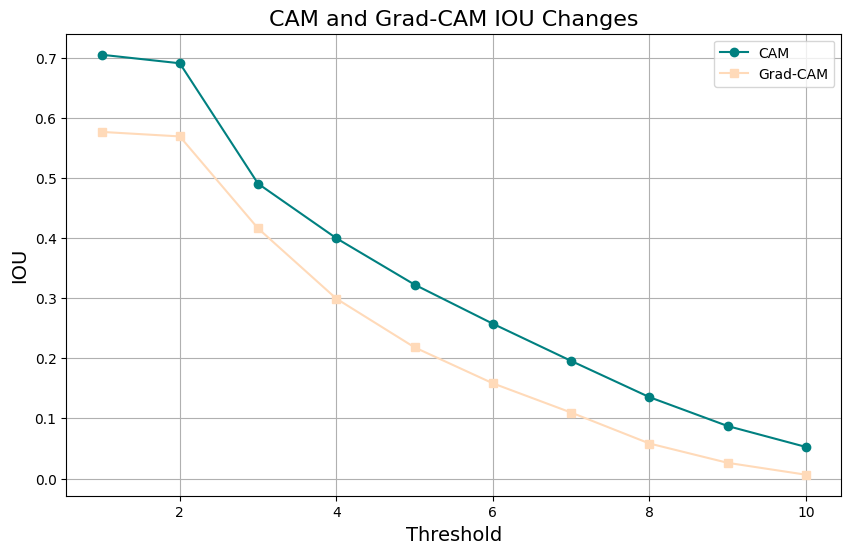

In [198]:
visualize_iou_on_threshold(item, cam_image, grad_cam_image)

In [199]:
grad_cam_image_b1 = generate_grad_cam(model, 'conv5_block1_out', item)

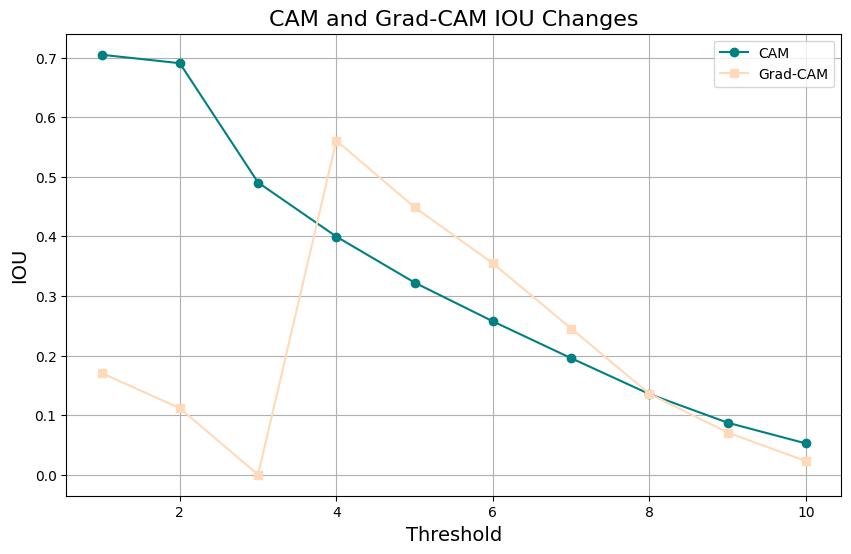

In [200]:
visualize_iou_on_threshold(item, cam_image, grad_cam_image_b1)

- 좀 더 앞 선 레이어에서 추출한 Grad-CAM의 결과:
    - 특정 구간의 임계값에서는 Grad-CAM이 보다 나은 Object Localization 성능을 보인다.
    - 단, 그 외 과반의 경우 Grad-CAM이 보다 낮은 IOU값을 기록했다.

Red: Ground Truth, Green: Grad-CAM, Blue: CAM


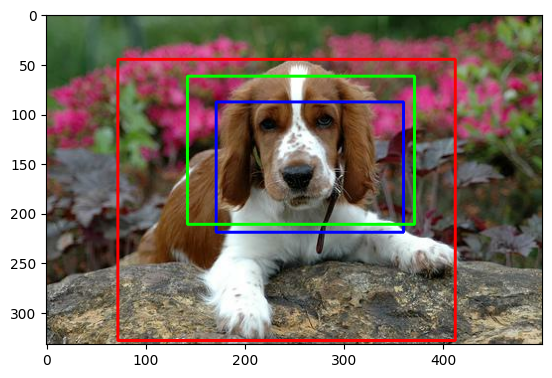

In [162]:
compare_bbox(item, cam_image, grad_cam_image_b1, threshold=0.5)

Red: Ground Truth, Green: Grad-CAM, Blue: CAM


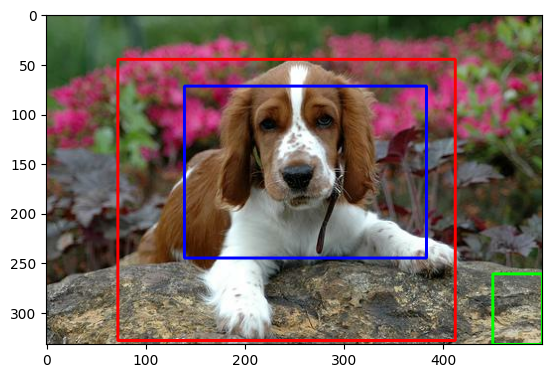

In [163]:
compare_bbox(item, cam_image, grad_cam_image_b1, threshold=0.25)

Red: Ground Truth, Green: Grad-CAM, Blue: CAM


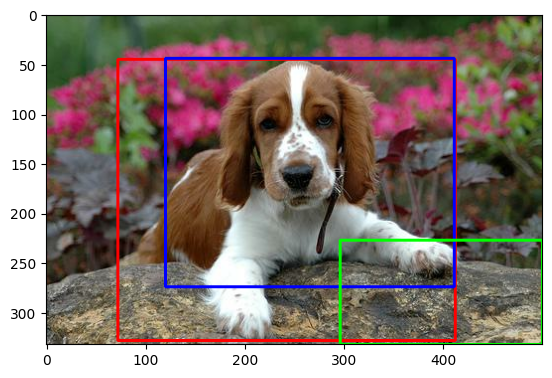

In [164]:
compare_bbox(item, cam_image, grad_cam_image_b1, threshold=0.1)

- 임계값이 일정값 이하로 떨어지면 아예 엉뚱한 곳에 Box를 그리는 것은 코드 구현상의 오류로 보이긴 한다.

# 추가 실험 2

- 다른 사진으로 비교해 보기

36


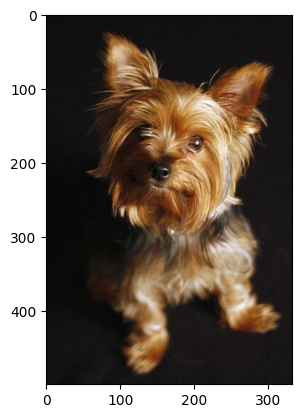

In [186]:
item2 = get_one(ds_train)
print(item2['label'])
plt.imshow(item2['image'])
plt.show()

In [205]:
cam_image2 = generate_cam(item2)
grad_cam_image2 = generate_grad_cam(model, 'conv5_block3_out', item2)
grad_cam_image2_b1 = generate_grad_cam(model, 'conv5_block1_out', item2)
grad_cam_image2_c4b6 = generate_grad_cam(model, 'conv4_block6_out', item2)

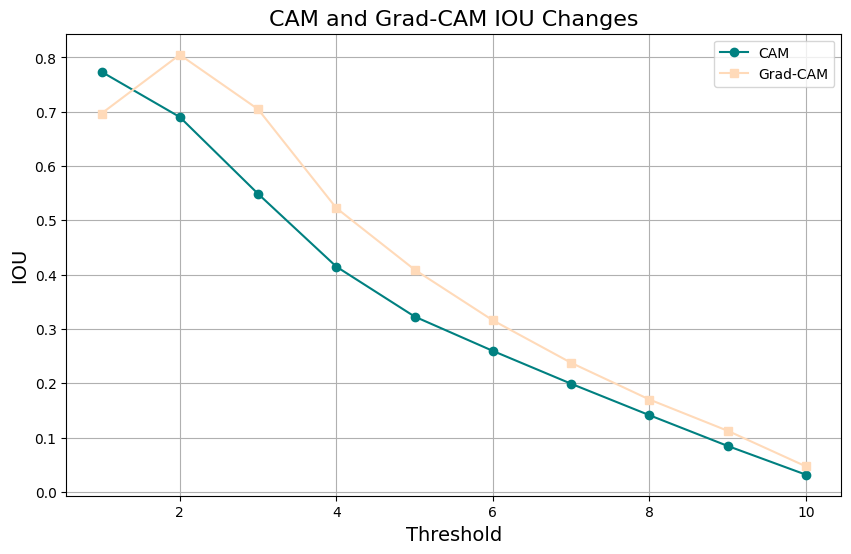

In [206]:
visualize_iou_on_threshold(item2, cam_image2, grad_cam_image2)

- 이번 사진에서는 대부분의 경우 Grad-CAM(마지막 레이어 사용)이 보다 나은 성능을 보였다.

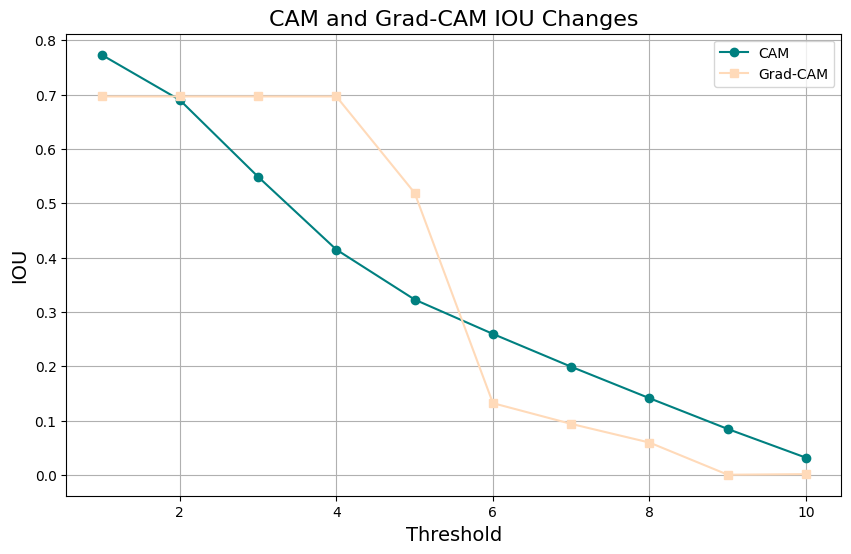

In [207]:
visualize_iou_on_threshold(item2, cam_image2, grad_cam_image2_b1)

- 마지막 직전 레이어 출력을 활용한 Grad-CAM의 경우는 일부 구간에서는 CAM 대비 월등한 성능을 보였으나, 나머지 구간에서 낮은 성능을 보였다.

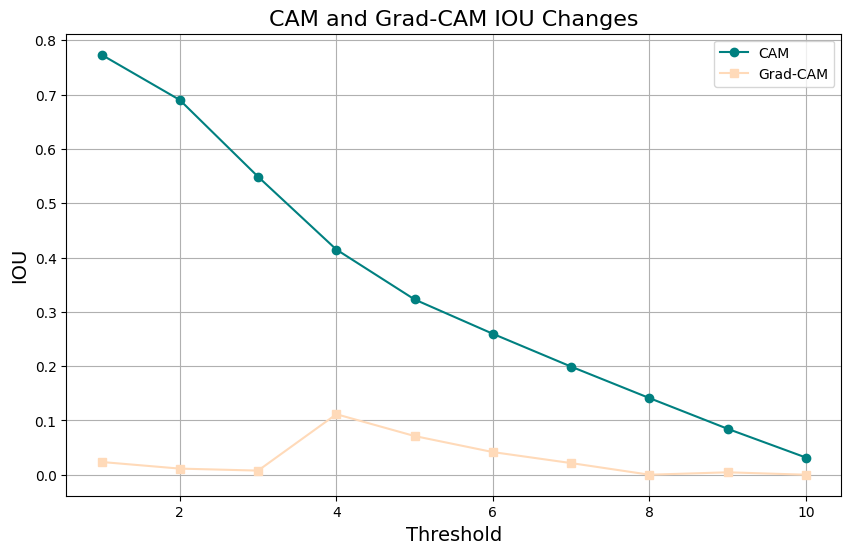

In [209]:
visualize_iou_on_threshold(item2, cam_image2, grad_cam_image2_c4b6)

- 보다 앞선 레이어 "conv4_block6_out"의 출력을 이용한 Grad-CAM은 오히려 성능이 크게 하락했다.

63


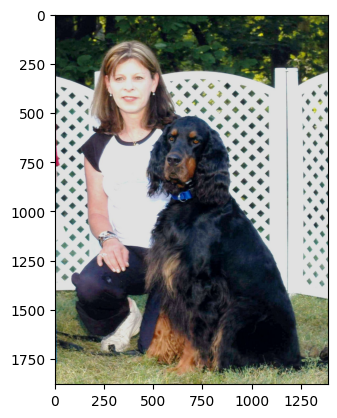

In [204]:
item3 = get_one(ds_train)
print(item3['label'])
plt.imshow(item3['image'])
plt.show()

In [210]:
cam_image3 = generate_cam(item3)
grad_cam_image3 = generate_grad_cam(model, 'conv5_block3_out', item3)
grad_cam_image3_b1 = generate_grad_cam(model, 'conv5_block1_out', item3)

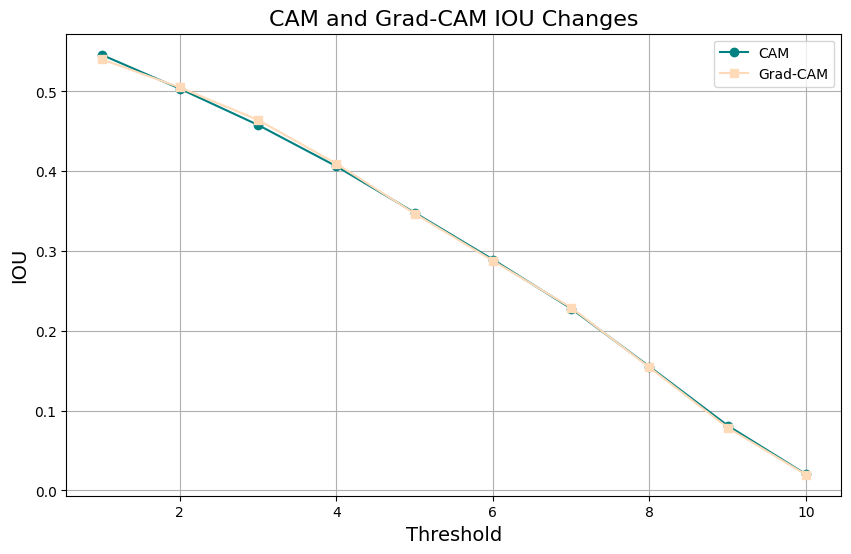

In [212]:
visualize_iou_on_threshold(item3, cam_image3, grad_cam_image3)

In [216]:
for thres in range(1, 10):
    compare_iou(item3, cam_image3, grad_cam_image3, threshold=thres*0.1)

Threshold: 0.1
CAM IOU 	: 50.34%
Grad-CAM IOU	: 50.50% (0.16%)
Threshold: 0.2
CAM IOU 	: 45.79%
Grad-CAM IOU	: 46.43% (0.63%)
Threshold: 0.30000000000000004
CAM IOU 	: 40.62%
Grad-CAM IOU	: 40.94% (0.32%)
Threshold: 0.4
CAM IOU 	: 34.81%
Grad-CAM IOU	: 34.70% (-0.11%)
Threshold: 0.5
CAM IOU 	: 28.93%
Grad-CAM IOU	: 28.77% (-0.16%)
Threshold: 0.6000000000000001
CAM IOU 	: 22.78%
Grad-CAM IOU	: 22.90% (0.11%)
Threshold: 0.7000000000000001
CAM IOU 	: 15.51%
Grad-CAM IOU	: 15.41% (-0.10%)
Threshold: 0.8
CAM IOU 	: 8.12%
Grad-CAM IOU	: 7.86% (-0.25%)
Threshold: 0.9
CAM IOU 	: 2.02%
Grad-CAM IOU	: 1.97% (-0.05%)


- 마지막 레이어 출력을 활용한 Grad-CAM이 CAM과 미세한 차이로 엎치락 뒤치락하지만 뒤지는 구간에서의 차이보다 우세한 구간에서의 차이가 더 크기 때문에 근소하게나마 Grad-CAM이 나은 성능을 보인다고 할 수 있다.

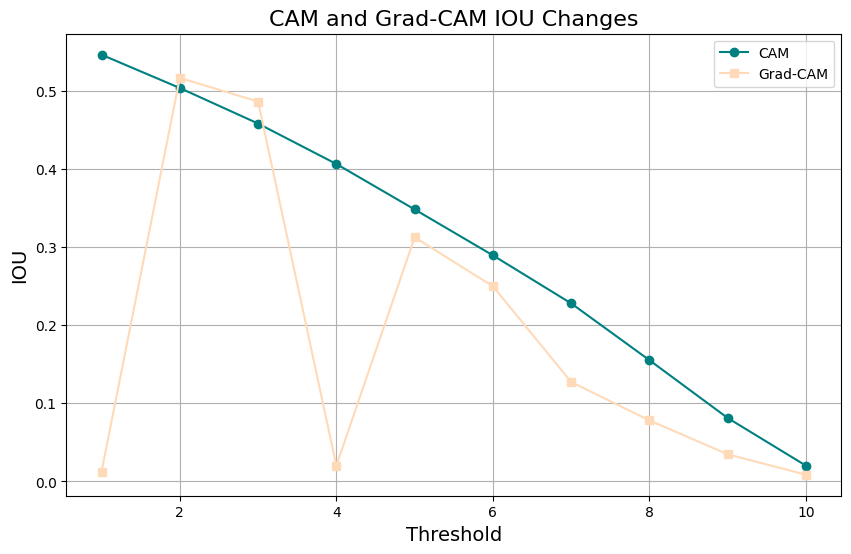

In [217]:
visualize_iou_on_threshold(item3, cam_image3, grad_cam_image3_b1)

- 좀 더 앞선 레이어 출력 층을 사용한 Grad-CAM은 성능이 하락한 모습을 보였다.

- 현재까지 총 3장의 이미지로 비교해 본 결과,
    - 마지막 층의 출력을 활용한 Grad-CAM의 성능이 임계값에 따라 요동치지 않고 안정적인 모습을 보였다.
    - 마지막 층의 출력을 활용한 Grad-CAM의 성능이 그 차이가 크지는 않지만 일반 CAM에 비해 다소 높은 성능을 보였다고 할 수 있다.
        - 아래 논문에 소개된 성능 비교표에서도 이번 실험과 유사하게 Grad-CAM이 근소한 차이로 우세한 것을 확인할 수 있다.

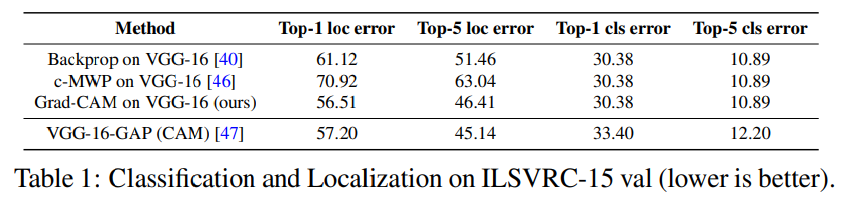

- 표 출처: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf)

# 추가 실험 3

**임계값을 고정해두고 여러 이미지에 대한 IOU 평균값을 비교해본다.**

- 300장의 샘플 준비

In [ ]:
def get_multiple(ds, num=300):
    ds = ds.take(num)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data

items = get_multiple(ds_train)

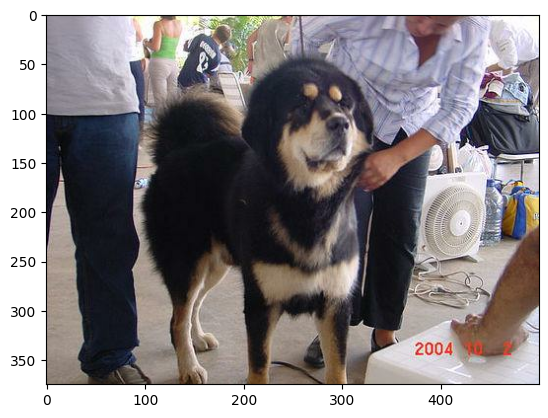

In [245]:
plt.imshow(items[299]['image'])
plt.show()

In [246]:
cam_ious, grad_ious = [], []

for i in range(len(items)):
    # CAM 생성
    cam_img = generate_cam(items[i])
    grad_cam_img = generate_grad_cam(model, 'conv5_block3_out', items[i])
    
    # IOU 계산 결과 추가
    cam_ious.append(get_iou(cam_img, items[i], threshold=0.5))
    grad_ious.append(get_iou(grad_cam_img, items[i], threshold=0.5))

# 각각의 방식의 IOU 평균값
np.mean(cam_ious), np.mean(grad_ious)

(0.3233443628605363, 0.3108333969244772)

- Train set에서 300개 샘플 기준으로 비교해 본 결과,
    - CAM 평균 IOU: 32.33%
    - Grad-CAM 평균 IOU: 31.08%
    - 1.25%p 차이로 Grad-CAM이 낮은 Object Localization 성능을 보였다.

In [247]:
items2 = get_multiple(ds_test)

In [248]:
cam_ious, grad_ious = [], []

for i in range(len(items2)):
    # CAM 생성
    cam_img = generate_cam(items2[i])
    grad_cam_img = generate_grad_cam(model, 'conv5_block3_out', items2[i])
    
    # IOU 계산 결과 추가
    cam_ious.append(get_iou(cam_img, items2[i], threshold=0.5))
    grad_ious.append(get_iou(grad_cam_img, items2[i], threshold=0.5))

# 각각의 방식의 IOU 평균값
np.mean(cam_ious), np.mean(grad_ious)

(0.31328451987605843, 0.22536191421005622)

- Test set에서 300개 샘플 기준으로 비교해 본 결과,
    - CAM 평균 IOU: 31.33%
    - Grad-CAM 평균 IOU: 22.54%
    - 8.79%p 차이로 Grad-CAM이 낮은 Object Localization 성능을 보였다.

In [260]:
cam_avg_iou = (0.3233443628605363 + 0.31328451987605843) / 2
grad_avg_iou = (0.3108333969244772+ 0.22536191421005622) / 2

print("600개 샘플에 대한 IOU 평균값:")
print(f"CAM \t\t: {cam_avg_iou:.2%}")
print(f"Grad-CAM\t: {grad_avg_iou:.2%} (-{(cam_avg_iou - grad_avg_iou):.2%}p)")

600개 샘플에 대한 IOU 평균값:
CAM 		: 31.83%
Grad-CAM	: 26.81% (-5.02%p)


# 결론

- **Grad-CAM 방식이 기존 CAM 방식에 비해 더 나은 Object Localization 성능을 보장하지 않는다.**

Grad-CAM 논문에서 실험한 데이터(ImageNet)와 모델 구조(VGG16)가 이번 프로젝트에서 사용된 데이터(Stanford Dogs)와 모델 구조(Resnet50)와 차이가 있으므로 이로인한 결과의 차이가 있을 수 있다. 또한, 이번 프로젝트에서 비교한 샘플의 수가 많지 않아 논문 대비 충분히 그 효과를 입증하기에 부족함이 있었을 수 있다는 점을 인정하지 않을 수 없다.

그러나 여전히 논문에서의 차이가 근소했다는 점, 이번 실험에서는 반대로 낮은 성능을 보였다는 점에서 미루어 볼때, "Grad-CAM 방식이 기존 CAM 방식에 비해 일반적으로 더 나은 Object Localization 성능을 보장하지 않는다"는 가설은 거짓이라 할 수 없다.

- **Grad-CAM은 기존 CAM 방식 대비 장점이 더 많은 것은 사실이다.**

기존 방식이 분류기를 재학습 시켜야 하는 번거로움과 이로인해 발생하는 성능 변화는 때로는 치명적일 수 있다.

그런 면에서 Grad-CAM은 Gradient를 활용하여 즉시 적용해 볼 수 있다는 점과 기존 방식의 단점을 피했다는 점 등 여러면에서 활용 이점을 갖는다.

성능에서 큰 차이를 보이지 않는다면 기존 CAM 방식의 치명적 단점을 피할 수 있고 그외 장점까지 있는 Grad-CAM방식을 사용하지 않을 이유가 없다.

일반적인 상황에서 Class Activation Map을 활용해야 한다면 Grad-CAM이 충분히 좋은 선택이 될 것이다.

# 회고

- 이번에도 예상했던 것과는 다른 결과가 나와서 다소 당황스럽지만 이것도 나름의 재미라고 생각이 들기도 한다.

- 데이터를 얻는 과정에서 오류가 여러번 발생했고 이를 수정하는 과정에서 자연스럽게 코드 흐름을 유심히 보게 됐다. 덕분에 다소 추상적인 흐름만 있었던 CAM, Grad-CAM 방식을 좀 더 구체적으로 이해할 수 있었던 시간이었다.

- Grad-CAM 방식에서 바운딩 박스가 완전히 엉뚱한 곳에 그려지는 경우가 발생했었는데 이 부분은 제대로 해결하지 못하는 것이 아쉽다.
    - 마지막 600개 샘플의 IOU 평균 값을 구할 때, 이전 실험에서 가장 안정적이었던 임계값 0.5으로 설정하긴 했으나 엉뚱한 바운딩 박스가 중간에 섞여 평균값을 크게 깎았을 가능성 역시 배제할 수 없다는 점이 가장 아쉬웠다.

---